In [1]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time
import cv2

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 20*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh


from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2024-04-09 11:04:21.309369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 11:04:21.416028: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 11:04:21.834615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-09 11:04:21.834680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-09 11:04:22.573007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-09 11:04:22.573299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-09 11:04:22.573694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-09 11:04:22.927501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-09 11:04:22.927673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Autosaving every 180 seconds


In [2]:
#load raw point cloud data from Newer College Dataset

#NEWER COLLEGE
idx = 900 #1500 
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
pc1 = np.flip(pc1, axis = 0)#flip to maintain CCW convention used in VICET

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
## purple -> green
color = 255*np.linspace(0,1,len(pc1)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(pc1, c=cname,  r = 3.5, alpha =0.5))
print(len(pc1) / 128)

#remove NaNs
# pc1[pc1[:,0]>64] = 100
# pc1[pc1[:,0]<-64] = 100
# pc1 = np.nan_to_num(pc1, nan=0.0)

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

512.0


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Convert Point Cloud to Depth Image

(64, 1024)


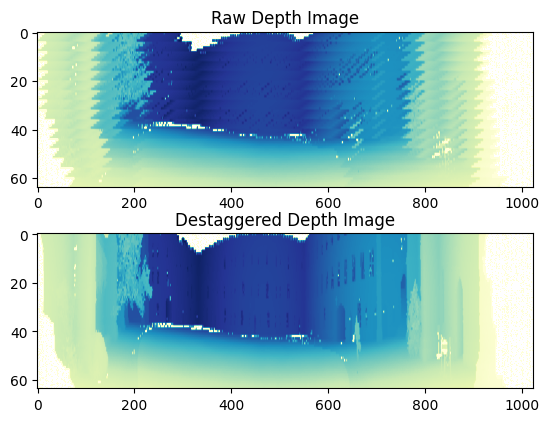

In [3]:
# %matplotlib notebook
pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
pcs = np.reshape(pc1_spherical, [-1,64,3])
pcs = np.flip(pcs, axis = 1)
raw_data = pcs[:,:,0].T

# print(np.shape(data))

data = np.zeros([64, 1024])
for i in range(np.shape(data)[0]//4):
    #shift left
#     data[4*i,:-18] = raw_data[4*i,18:]
#     data[4*i+1,:-12] = raw_data[4*i+1,12:]
#     data[4*i+2,:-6] = raw_data[4*i+2,6:]
#     data[4*i+3,:] = raw_data[4*i+3,:]
#     #shift right
#     data[4*i,:] = raw_data[4*i,:]
#     data[4*i+1,6:] = raw_data[4*i+1,:-6]
#     data[4*i+2,12:] = raw_data[4*i+2,:-12]
#     data[4*i+3,18:] = raw_data[4*i+3,:-18]
    #keep centered-- avoids needing to fill in gaps
#     data[4*i,:-9] = raw_data[4*i,9:]
#     data[4*i+1,:-3] = raw_data[4*i+1,3:]
#     data[4*i+2,3:] = raw_data[4*i+2,:-3]
#     data[4*i+3,9:] = raw_data[4*i+3,:-9]
    data[4*i,1:-8] = raw_data[4*i,9:]
    data[4*i+1,1:-2] = raw_data[4*i+1,3:]
    data[4*i+2,4:] = raw_data[4*i+2,:-4]
    data[4*i+3,10:] = raw_data[4*i+3,:-10]
    
# data = np.flip(data, axis =1)

fig, ax = p.subplots(2,1)
ax[0].set_title("Raw Depth Image")
ax[0].imshow(raw_data, cmap = "YlGnBu", norm='log')
ax[0].set_aspect(5)
ax[1].set_title("Destaggered Depth Image")
ax[1].imshow(data, cmap = "YlGnBu", norm='log')
ax[1].set_aspect(5)
print(np.shape(data))


# Reproject 2D Depth image back to 3D point cloud

#### IMPORTANT: look into pixel_shift_by_row parameter from OUSTER
https://ouster.com/insights/blog/firmware-2-4-industry-standard-protocols-and-improved-alerts

In [4]:
#OS1 LiDAR Intrinsics
#as specified in datasheet
# phimin = np.deg2rad(-16.6) #supposed to be this
# phimax = np.deg2rad(16.6)
#angles required to reproduce observed point clouds
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
depth_img  = data.T

new_point_cloud_spherical = np.zeros([np.shape(pcs)[0]*np.shape(pcs)[1],3])
pc1_spherical = new_point_cloud_spherical

count = 0
for w in range(np.shape(depth_img)[0]):
    for h in range(np.shape(depth_img)[1]):
        new_point_cloud_spherical[count,0] = depth_img[w,h] #radius
        new_point_cloud_spherical[count,1] = 2*np.pi*(w/np.shape(depth_img)[0]) #theta
        new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth_img)[1]) #phi
        count+= 1

new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 

#shape image to have same angular field of view in width and height
vert_fov = np.rad2deg(phimax-phimin)
# print(vert_fov)
# vert_fov/360
# print((vert_fov/360)*np.shape(pcs)[0])

In [5]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

## purple -> green
color = 255*np.linspace(0,1,len(new_point_cloud_cart)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(new_point_cloud_cart, c=cname,  r = 3.5, alpha =0.5))
# disp.append(Points(new_point_cloud_cart[::32], c='red',  r = 3.5, alpha =0.8))
# disp.append(Points(new_point_cloud_cart[::4], c='blue',  r = 5., alpha =0.125))

disp.append(Points(pc1, c = 'blue', r = 3.5, alpha = 0.5))

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Load ground truth poses (map frame) and convert to NeRF LH Coordinate System

(-150.0, 30.0)

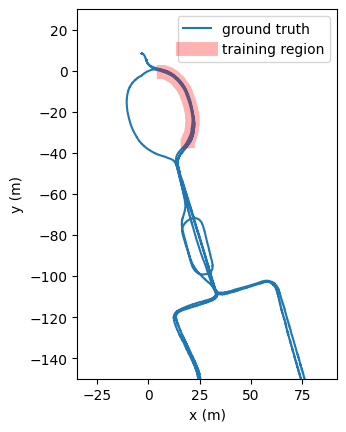

In [40]:
from os import listdir

dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
# print(fn_gt)

#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# print(np.shape(gt))
# print(gt[20,:])

scan_dir = dir_name + experiment_name + "raw_format/ouster_zip_files/ouster_scan-007/ouster_scan/"
list_of_all_scans = sorted(listdir(scan_dir))

#plot ground truth trajectory
fig, ax = p.subplots()
ax.set_aspect('equal')
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.plot(gt[:,2], gt[:,3], label = "ground truth")

#superimpose trajectory from <short_experiment_01>
# first_timestamp = int(list_of_all_scans[0][6:16])
# last_timestamp = int(list_of_all_scans[-1][6:16]) #scrape timestamp from name of velodyne .pcl file
# first_idx = np.argwhere(gt[:,0] == first_timestamp)[0][0]
# last_idx = np.argwhere(gt[:,0] == last_timestamp)[0][0]
first_idx = 600 #1450 #700
last_idx = 1000 #1950 #1000

ax.plot(gt[first_idx:last_idx,2], gt[first_idx:last_idx,3], 'r', lw = 10, alpha = 0.3, label = 'training region')
ax.legend(loc = 'best')
ax.set_ylim([-150,30])

In [178]:
from time import sleep
#convert gt from xyzquat to homogenous rotation matrix
n_images = 50 #20 
n_rots = 8 #8 
#Ouster OS1-64
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
#just for debug
# phimin = np.deg2rad(-6) 
# phimax = np.deg2rad(27.75)
# phimin = -0.53529248 #rad
# phimax = 0.18622663 #rad
vert_fov = np.rad2deg(phimax-phimin)

poses = np.zeros([n_images*n_rots,4,4])
images = np.ones([n_images*n_rots, 64, 64, 2]) #depth image and raydrop

#focal length (in pixels) = Image Size / (2 tan(FOV/2)) #needs to be array!
focal = np.array(np.shape(images)[1]/(2*np.tan((phimax-phimin)/2))) #default image size
H, W = images.shape[1:3]
print(focal, H, W)

for i in range(n_images):
    #load point cloud
    idx = i*10 + 600 #1450 #700    
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
    pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

    #convert to depth image
    pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
    pcs = np.reshape(pc1_spherical, [-1,64,3])
    pcs = np.flip(pcs, axis = 1)
    raw_data = pcs[:,:,:]
    raw_data = np.transpose(pcs, [1,0,2])

    #destagger depth images (OS1 unit has delay in sensor return bus)
    data = np.zeros([64, 1024])
    for k in range(np.shape(data)[0]//4):
        data[4*k,1:-8] = raw_data[4*k,9:,0]
        data[4*k+1,1:-2] = raw_data[4*k+1,3:,0]
        data[4*k+2,4:] = raw_data[4*k+2,:-4,0]
        data[4*k+3,10:] = raw_data[4*k+3,:-10,0]
    data = np.flip(data, axis =1)

#     print(np.shape(data))
#     print(np.shape(pc1_spherical))

    for j in range(n_rots):
        
        #get cropped depth image ~~~~~~~~~~~~~~~~~~~~
#         pcs = np.flip(data, axis = 1) #flip vertical
#         pcs = np.flip(pcs, axis = 0) #flip horizontal to look at first clockwise patch of scan sweep 
#         pcs = pcs.T
        pcs = data.T
        
        #resize image to 64x64
        image_width = int((vert_fov/360)*np.shape(pcs)[0])        
#         pcs = pcs[j*image_width:(j+1)*image_width,:].T #SQUARE
        pcs = pcs[(j+1)*image_width:(j+2)*image_width,:].T #SQUARE-- skip beginning of frame (blocked by human)
#         pcs = pcs[(j*image_width//32):((j+1)*image_width//32),:,0].T #32nds
        pcs = cv2.resize(pcs, (64, 64), cv2.INTER_NEAREST) #keep square
        #TEST
#         pcs = np.flip(pcs, axis =1)
    
        #preserve aspect ratio and focal length but just take middle
#         pcs = pcs[:,31:33] #uncomment for 32nds
        images[j+(i*n_rots),:,:,0] = pcs #save depth information to first channel
        a = np.argwhere(pcs == 0)
        #TODO: why do some distant windows register as being close (but not non-returns)??
        images[j+(i*n_rots),a[:,0],a[:,1],1] = 0 #save raydrop mask to 2nd channel
        
        #get transformation matrix ~~~~~~~~~~~~~~~~~~
        rotm = np.eye(4)
        rotm[1,3] = -gt[idx,2] #x
        rotm[2,3] = gt[idx,3] #y
        rotm[0,3] = -gt[idx,4] #z
        rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 

# #         #orient yellow (-z) pointing forward
        fix1 = R.from_euler('xyz', [0,-np.pi/2,0]).as_matrix()
        fix2 = R.from_euler('xyz', [np.pi/2,0,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ fix1 @ fix2

        #unreliable?
        temp = R.from_matrix(rotm[:3,:3]).as_euler('zxy')
        rotm[:3,:3] = R.from_euler('xyz', [temp[0], temp[1], -temp[2]]).as_matrix()
                
        #account for image crop in rotation
        #swapping sign convention from what was used in synthetic data(?) ...+j*(phimax-phimin)
#         crop_angle = 0 #DEBUG ONLY
#         crop_angle = -(phimax-phimin)/2 + j*(phimax-phimin) #square
        crop_angle = -(phimax-phimin)/2 + (j+1)*(phimax-phimin) #square-- but skip beginning of frame
        #         crop_angle = -(phimax-phimin)/64 - j*(phimax-phimin)/32 #2-pixels wide
        
        #account for the fact that sensor points back and to the left
        crop_angle -= np.pi/4 
        rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix() #looks better
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

        #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
        sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix() #was this
#         sensor_elevation_zero_rotm = R.from_euler('xyz', [0,(phimin+phimax)/2,0]).as_matrix() #TODO: not sure if rot about y or z
        rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm

        #flip x and z axis
#         rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 
#         rotm[0,-1], rotm[1,-1] = rotm[1,-1], rotm[0,-1]  #test

# #         # flip sign of axis
#         rotm[0:3,2] *= -1 #was this
#         rotm[0:3,1] *= -1 #was this
#         rotm[0:3,0] *= -1 #test
#         rotm = rotm[[1,0,2,3],:] #was this
#         rotm = rotm[[2,0,1,3],:]
#         rotm[2,:] *= -1 # flip whole world upside down
#         #translate all frames above xy plane
        rotm[2,-1] += 45 
        
        #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
        rotm[:3,-1] *= 0.05
        images[j+(i*n_rots),:,:,0] *= 0.05
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        poses[j+(i*n_rots)] = rotm

images = images.astype(np.float32)
poses = poses.astype(np.float32)
        
# test on one only
testimg, testpose = images[(n_images*n_rots)-1], poses[(n_images*n_rots)-1]
images = images[:((n_images*n_rots)-1),...,:3]
poses = poses[:((n_images*n_rots)-1)]

# #90/10 split
# cutoff = (n_images*9)//10
# print(cutoff)
# testimg, testpose = images[cutoff:], poses[cutoff:]
# images = images[:cutoff,...,:3]
# poses = poses[:cutoff]

105.48986268602624 64 64


In [179]:
#draw orientation of frames used for each patch in world frame
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
for i in range(np.shape(images)[0]-1):
    #convert depth image back to point cloud
    count = 0
    for w in range(np.shape(images)[1]):
        for h in range(np.shape(images)[2]):
            new_point_cloud_spherical[count,0] = images[i,w,h,0] #radius
            new_point_cloud_spherical[count,1] = -(phimax-phimin)*(w/np.shape(images)[1]) #theta
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(images)[2]) #phi
            count+= 1
            
    #transform each to base frame using <poses>
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z -- does this indicate an error somewhere???

    #draw frames for each sub-scan 
    alph = 1-(i%(n_rots)/n_rots)
    #forward view direction (-z in NeRF c2w convention)
    headings = poses[i,:3,:3] @ np.array([0,0,-0.03])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "yellow", alpha = alph))
    # x
    headings = poses[i,:3,:3] @ np.array([.03,0,0])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "red", alpha = alph))
    #y
    headings = poses[i,:3,:3] @ np.array([0,.03,0])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "green", alpha = alph))
    #z
    headings = poses[i,:3,:3] @ np.array([0,0,.03])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "blue", alpha = alph))
disp.append(Points(np.array([[0,0,0]]), r = 10, c = 'black'))
plt.show(disp, "Training Data Sample")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

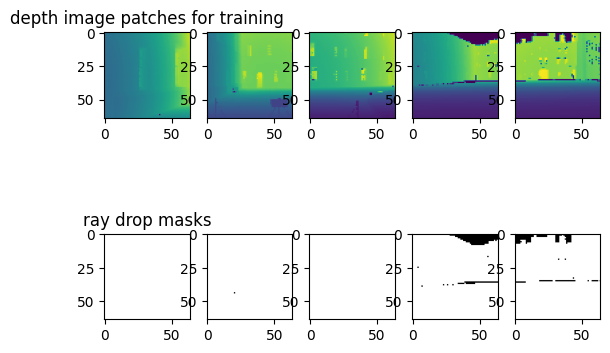

In [177]:
# %matplotlib notebook
fig, ax = p.subplots(2,5)
ax[0,0].set_title("depth image patches for training")

# ax[0,0].imshow(images[0,:,:,0])#, vmin=0, vmax=64)
# ax[0,1].imshow(images[1,:,:,0])#, vmin=0, vmax=64)
# ax[0,2].imshow(images[2,:,:,0])#, vmin=0, vmax=64)
# ax[0,3].imshow(images[3,:,:,0])#, vmin=0, vmax=64)
# ax[0,4].imshow(images[4,:,:,0])#, vmin=0, vmax=64)

ax[0,0].imshow(images[-4,:,:,0])#, vmin=0, vmax=64)
ax[0,1].imshow(images[-3,:,:,0])#, vmin=0, vmax=64)
ax[0,2].imshow(images[-2,:,:,0])#, vmin=0, vmax=64)
ax[0,3].imshow(images[-1,:,:,0])#, vmin=0, vmax=64)
ax[0,4].imshow(testimg[:,:,0])#, vmin=0, vmax=64)

ax[1,0].set_title("ray drop masks")
ax[1,0].imshow(images[-4,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,1].imshow(images[-3,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,2].imshow(images[-2,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,3].imshow(images[-1,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,4].imshow(testimg[:,:,1],cmap="gray", vmin=0,vmax=1)

# Debug: draw frames

In [160]:
#Raw frames, in Newer College RHCS convention
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

# new_point_cloud_spherical = np.zeros([np.shape(images)[1]*np.shape(images)[2],3])

for i in range(n_images):
    idx = i*20 + 600    
    
    rotm = np.eye(4)
    rotm[0,3] = gt[idx,2] #x
    rotm[1,3] = gt[idx,3] #y
    rotm[2,3] = gt[idx,4] #z
    rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 
    
    #draw frames for each sub-scan 
    alph = 1-(i/n_images)
    #forward view direction (-z in NeRF c2w convention)
    headings = rotm[:3,:3] @ np.array([0,0,-1])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "yellow", alpha = alph))
    # x
    headings = rotm[:3,:3] @ np.array([1,0,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "red", alpha = alph))
    #y
    headings = rotm[:3,:3] @ np.array([0,1,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "green", alpha = alph))
    #z
    headings = rotm[:3,:3] @ np.array([0,0,1])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "blue", alpha = alph))

disp.append(Points(np.array([[0,0,0]]), r = 10, c = 'black'))
plt.show(disp, "Actual Ground Truth Path (Newer College Frame)")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Train Network

In [171]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 10 #6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256): #8,256
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)

    #extend "color" channels to small MLP after output of density channel
    sigma_channel = dense(1, act=None)(outputs)
    
    #start ray drop branch
    rd_start = tf.concat([outputs, inputs], -1)
    rd_channel = dense(128, act=relu)(outputs)
#     rd_channel = dense(128, act=relu)(rd_channel)
    rd_channel = dense(128, act=relu)(rd_channel)
    rd_channel = dense(1, act=tf.keras.activations.sigmoid)(rd_channel)
    out = tf.concat([sigma_channel, rd_channel], -1)
    model = tf.keras.Model(inputs=inputs, outputs=out)
    
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')

    #spherical projection model (ours)~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    phimin = np.deg2rad(-16) 
    phimax = np.deg2rad(17.75)

    #[r, theta, phi]
    dirs_test = tf.stack([-tf.ones_like(i), #r
                          #theta
#                           ((i-31.5)/63)*(phimax-phimin), #was this
                          ((i-32)/64)*(phimax-phimin), #fixes slight overlap
                          #phi
#                           (phimax + phimin)/2 + ((j-31.5)/63)*(phimax-phimin) -np.pi/2 #rows in wrong order
                          (phimax + phimin)/2 + ((-j+31.5)/63)*(phimax-phimin) -np.pi/2
                         ], -1)
    dirs_test = tf.reshape(dirs_test,[-1,3])
    dirs_test = LC.s2c(LC, dirs_test) 
    
    rotm = R.from_euler('xyz', [0,-np.pi/2 + (phimax + phimin)/2,0]).as_matrix()
    dirs_test = dirs_test @ rotm
    dirs_test = dirs_test @ tf.transpose(c2w[:3,:3])
    dirs = dirs_test @ (c2w[:3,:3] 
                          @ R.from_euler('xyz', [0,0,np.pi/2]).as_matrix()
                          @ np.linalg.pinv(c2w[:3,:3]) )

    dirs = tf.reshape(dirs, [64,64,3]) #square
    
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * np.eye(3), -1) 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
        
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d


def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=True):

    def batchify(fn, chunk=1024*512): #1024*128 converged for box3 #1024*32 in TinyNeRF
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    #[image_height, image_width, batch_size, 3]
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
#     raw = tf.reshape(raw, list(pts.shape[:-1]) + [4]) #OG nerf
#     raw = tf.reshape(raw, list(pts.shape[:-1]) + [1])  #[depth]
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [2]) # [depth, ray drop] 
    
    # Compute opacities and colors
    #OG TinyNeRF
#     sigma_a = tf.nn.relu(raw[...,3])
#     rgb = tf.math.sigmoid(raw[...,:3]) 
    #LiDAR-NeRF
    sigma_a = tf.nn.relu(raw[...,0])
    ray_drop = tf.nn.relu(raw[...,1])
#     ray_drop = tf.math.sigmoid(raw[...,1]) #test

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

#     print("weights[...,None]",np.shape(weights[..., None]))
#     print("ray_drop", np.shape(ray_drop))
#     print(np.shape(weights), np.shape(z_vals))
    
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    ray_drop_map = tf.reduce_sum(weights * ray_drop, -1) #axis was -2, changed to -1 
    acc_map = tf.reduce_sum(weights, -1)

#     return depth_map, acc_map
    return depth_map, acc_map, ray_drop_map

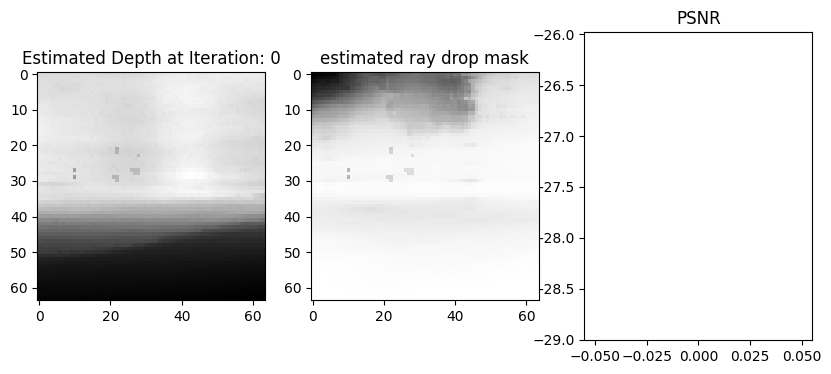

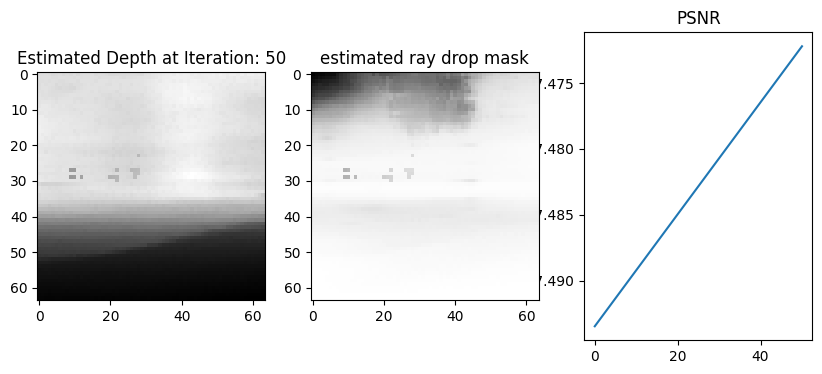

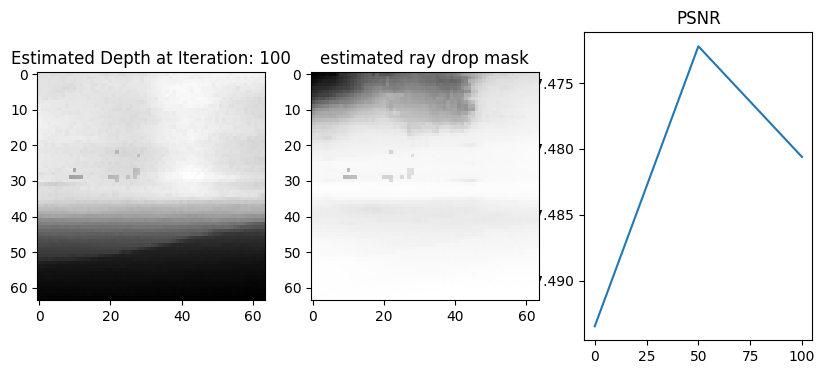

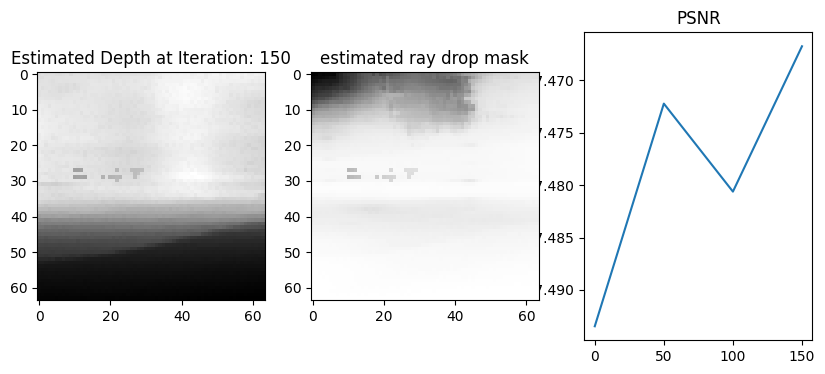

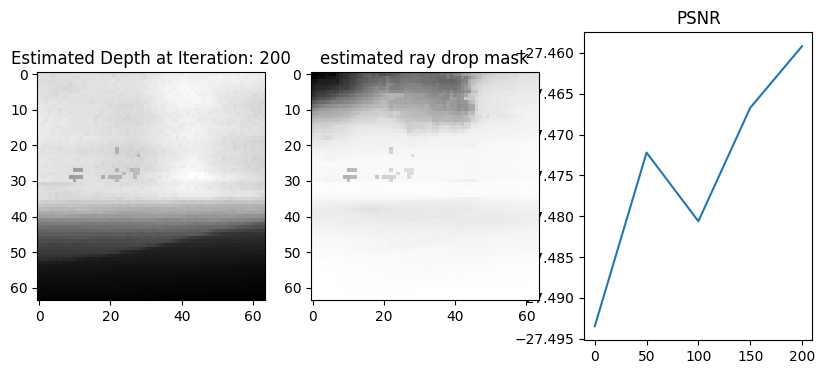

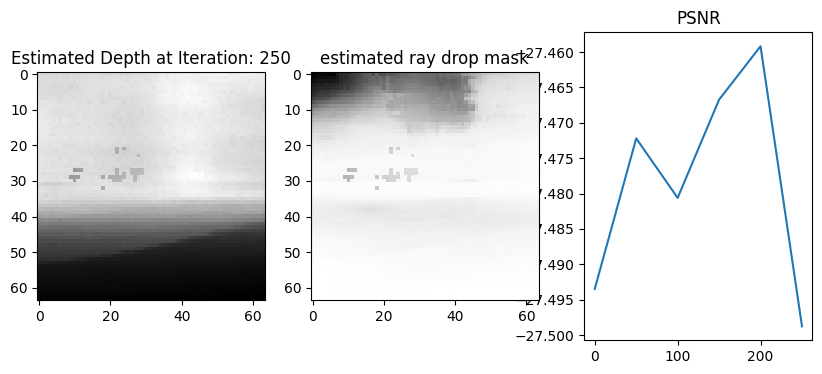

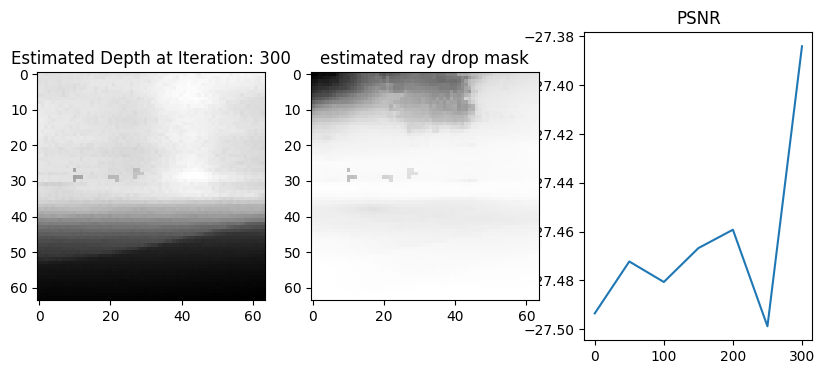

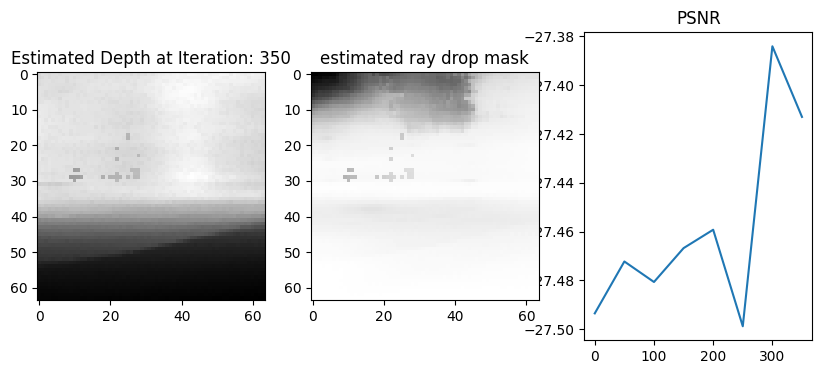

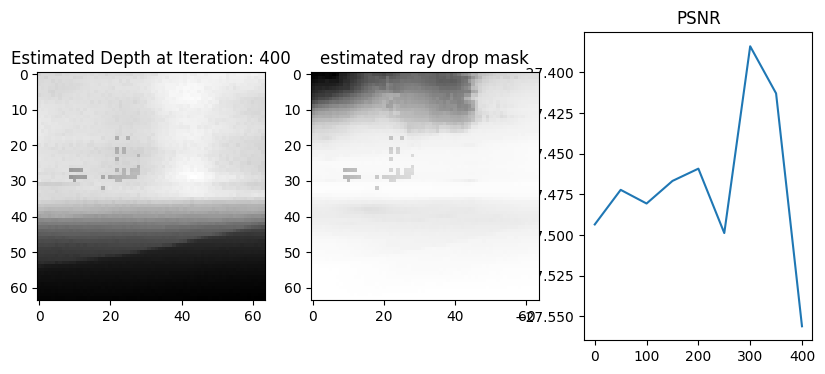

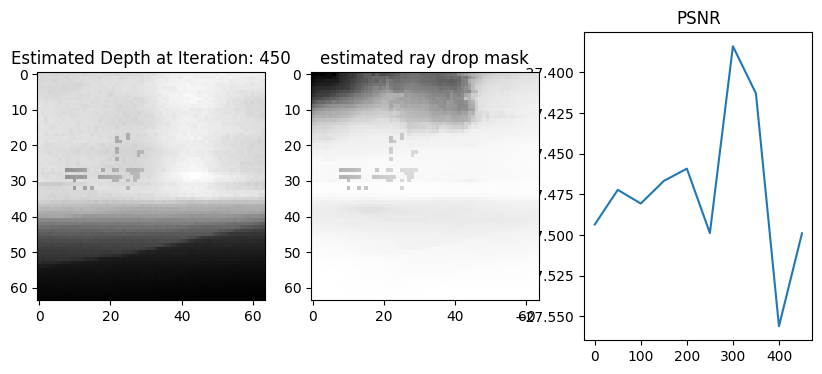

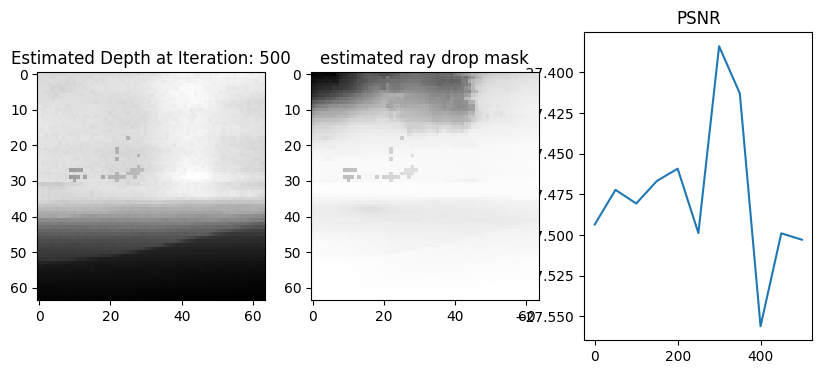

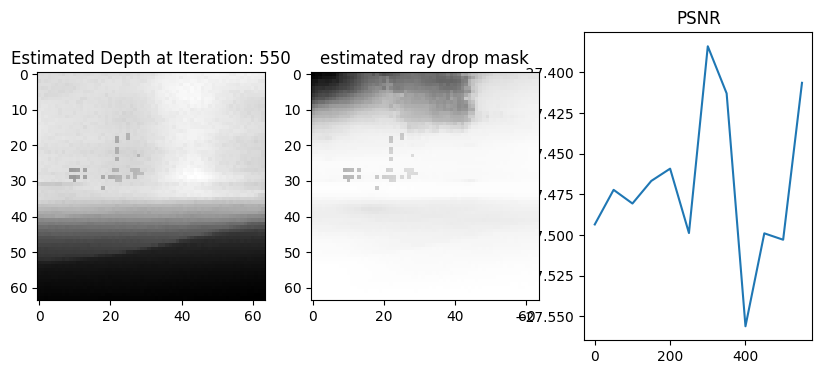

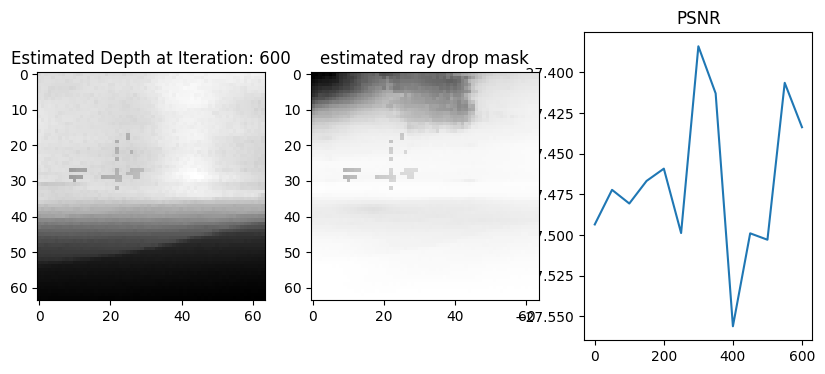

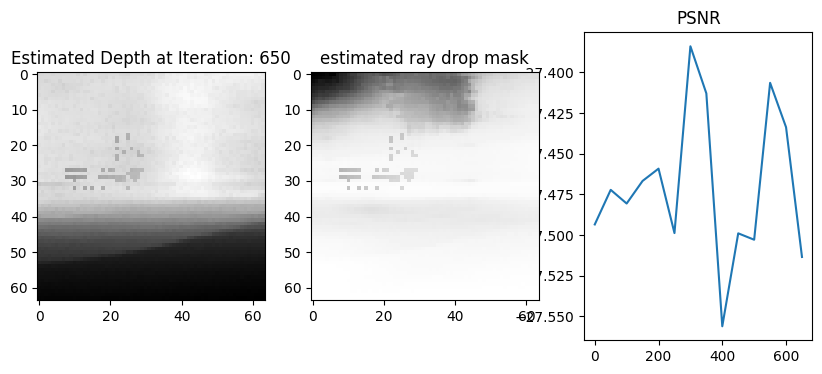

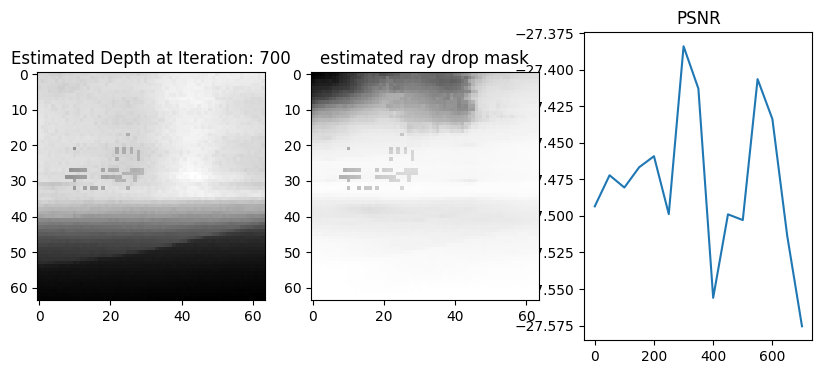

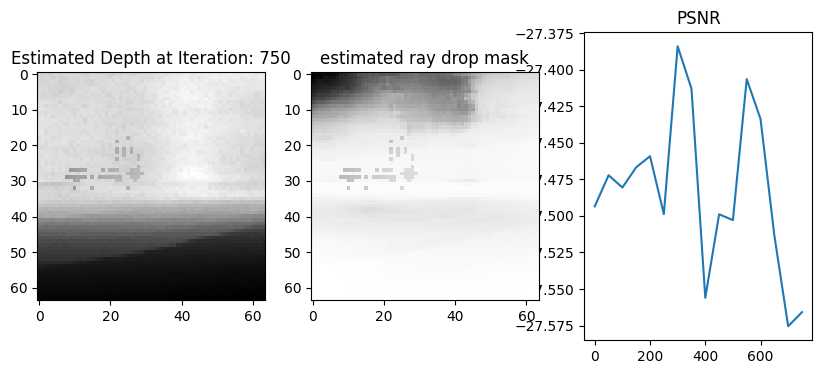

KeyboardInterrupt: 

In [174]:
# model = init_model()
# optimizer = tf.keras.optimizers.Adam(5e-4) #default tiny-NeRF
optimizer = tf.keras.optimizers.Adam(5e-5)

N_samples = 256 #256 #64 #decrease as needed for VRAM
N_iters = 50_000
psnrs = []
iternums = []
i_plot = 50

import time
t = time.time()
for i in range(N_iters+1):
    img_i = np.random.randint(images.shape[0])
    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]
    #get ray origins and ray directions
    rays_o, rays_d = get_rays(H, W, focal, pose)
    
    with tf.GradientTape() as tape:
        #just calculate loss via comparing depth output vs target (should also be depth!)
        depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=4., N_samples=N_samples, rand=True)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        
#         print(np.shape(depth), np.shape(target))
#         print(np.shape(ray_drop), np.shape(target_drop_mask))
        
        #default loss from TinyNERF
#         loss = tf.reduce_mean(tf.square(depth - target)) 
        #Distance Loss only
#         loss = tf.reduce_mean(tf.abs(depth - target)) # <-- works way better than dist^2
    
        #LiDAR-NeRF LoSS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        ## L_total = L_dist + lam1*L_intensity + lam2*L_raydrop + lam3*L_reg
        ##          lam1=1, lam2=1, lam3=100
        ## L_reg --> structural regularization: consider gradient loss only on high-texture areas
        
        #Gradient Loss (structural regularization for smooth surfaces)
        thresh = 0.025 #was 0.1 in LiDAR-NeRF
        mask = np.zeros(np.shape(target[:,:,0]))
        vertical_grad_target = np.gradient(target[:,:,0])[0] 
        vertical_past_thresh = np.argwhere(tf.abs(vertical_grad_target) > thresh)
        mask[vertical_past_thresh[:,0], vertical_past_thresh[:,1]] = 1
        horizontal_grad_target = np.gradient(target[:,:,0])[1]
        horizontal_past_thresh = np.argwhere(tf.abs(horizontal_grad_target) > thresh)
        mask[horizontal_past_thresh[:,0], horizontal_past_thresh[:,1]] = 1
        vertical_grad_inference = np.gradient(depth[:,:,0])[0]
        horizontal_grad_inference = np.gradient(depth[:,:,0])[1]
        mag_difference = tf.math.sqrt((vertical_grad_target-vertical_grad_inference)**2 + (horizontal_grad_target-horizontal_grad_inference)**2)
#         L_reg = tf.reduce_mean(np.multiply(mag_difference, mask))
        #suppress ray drop areas
        L_reg = np.multiply(mag_difference, mask)
        L_reg = tf.reduce_mean(tf.multiply(L_reg, target_drop_mask))
        L_reg = tf.cast(L_reg, tf.float32)            
                
        #ray drop loss
        L_raydrop = tf.keras.losses.binary_crossentropy(target_drop_mask, ray_drop)
        L_raydrop = tf.math.reduce_mean(tf.abs(L_raydrop))
#         print("Ray Drop Loss:", L_raydrop)
    
        #distance loss
#         L_dist = tf.reduce_mean(tf.abs(depth - target)) #simple loss
        #suppressing ray drop areas
        depth_nondrop = tf.math.multiply(depth, target_drop_mask)
        target_nondrop = tf.math.multiply(target, target_drop_mask)
        L_dist = tf.reduce_mean(tf.abs(depth_nondrop - target_nondrop))
    
        lam1 = 100
        lam2 = 1 #1/(64**2)
        loss = L_dist + lam1*L_reg + lam2*L_raydrop       

#         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        t = time.time()
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose) #constant validation image
#         sampl = int(np.random.uniform(low=0, high=len(testpose)-1))        
#         rays_o, rays_d = get_rays(H, W, focal, testpose[sampl]) #90/10 split
#         depth, acc = render_rays(model, rays_o, rays_d, near=1., far=64., N_samples=N_samples)
        depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=4., N_samples=N_samples)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
#         print(ray_drop)
#         #simple depth only
#         loss = tf.reduce_mean(tf.square(depth[:,:,None] - testimg[:,:,0])) 
#         #ray drop only
#         L_raydrop = tf.keras.losses.binary_crossentropy(testimg[:,:,1], ray_drop)
#         loss = tf.math.reduce_sum(tf.abs(L_raydrop)).numpy()

        #LiDAR-NeRF LoSS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        ## L_total = L_dist + lam1*L_intensity + lam2*L_raydrop + lam3*L_reg
        ##          lam1=1, lam2=1, lam3=100
        ## L_reg --> structural regularization: consider gradient loss only on high-texture areas
        
        target = testimg[:,:,:1]
        target_drop_mask = testimg[:,:,1:]
        
        #Gradient Loss (structural regularization for smooth surfaces)
        thresh = 0.025 #was 0.1 in LiDAR-NeRF
        mask = np.zeros(np.shape(target[:,:,0]))
        vertical_grad_target = np.gradient(target[:,:,0])[0] 
        vertical_past_thresh = np.argwhere(tf.abs(vertical_grad_target) > thresh)
        mask[vertical_past_thresh[:,0], vertical_past_thresh[:,1]] = 1
        horizontal_grad_target = np.gradient(target[:,:,0])[1]
        horizontal_past_thresh = np.argwhere(tf.abs(horizontal_grad_target) > thresh)
        mask[horizontal_past_thresh[:,0], horizontal_past_thresh[:,1]] = 1
        vertical_grad_inference = np.gradient(depth[:,:,0])[0]
        horizontal_grad_inference = np.gradient(depth[:,:,0])[1]
        mag_difference = tf.math.sqrt((vertical_grad_target-vertical_grad_inference)**2 + (horizontal_grad_target-horizontal_grad_inference)**2)
        L_reg = tf.reduce_mean(np.multiply(mag_difference, mask))
#         L_reg = tf.reduce_mean(tf.abs(np.multiply(vertical_grad_target-vertical_grad_inference, mask)))
        L_reg = tf.cast(L_reg, tf.float32)     
        #suppress ray drop areas
        L_reg = np.multiply(mag_difference, mask)
        L_reg = tf.reduce_mean(tf.multiply(L_reg, target_drop_mask))
        L_reg = tf.cast(L_reg, tf.float32)            
    
        #distance loss
        L_dist = tf.reduce_mean(tf.abs(depth - target))
        
        #ray drop loss
        L_raydrop = tf.keras.losses.binary_crossentropy(target_drop_mask, ray_drop)
        L_raydrop = tf.math.reduce_sum(tf.abs(L_raydrop))
#         print("Ray Drop Loss:", L_raydrop)
        
        lam1 = 100
        lam2 = 1 #1/(64**2)
        loss = L_dist + lam1*L_reg + lam2*L_raydrop       

#         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
#         p.imshow(testimg[:,:,1],cmap = "gray") #, norm='log')
#         p.title(f'Actual Mask at Iteration: {i}')
        p.subplot(133)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        #look at depth map
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()
print('Done')

# Infer point cloud at novel frame

In [183]:
num_rots =  11
N_samples = 256 #64 #does not have to match what was used in training?? 

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

for j in range(num_rots):
# for j in np.linspace(0,7,15):
    #get sensor transformation matrix
    rotm = np.eye(4)

    # account for image crop in rotation -------------------
#     crop_angle = -(phimax-phimin)/2 - j*(phimax-phimin)#square
    crop_angle = -(phimax-phimin)/2 + (j+1)*(phimax-phimin)#square-- skip first
#     crop_angle = -(phimax-phimin)/16 - j*(phimax-phimin)/8 #eighth
#     crop_angle = -(phimax-phimin)/32 - j*(phimax-phimin)/16 #1/16
#     crop_angle = -(phimax-phimin)/32 - j*(phimax-phimin)/32 #1/32
#     rotm_crop = R.from_euler('xyz', [0,-crop_angle,0]).as_matrix()
    rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix() #looks better
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

    #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
    sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix()
    rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
    # ------------------------------------------------------

    # flip x and z axis
    rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

    rotm[0:3,2] *= -1 # flip sign of y and z axis
    rotm[0:3,1] *= -1
    rotm = rotm[[1,0,2,3],:]
    rotm[2,:] *= -1 # flip whole world upside down
    rotm[2,-1] = 0.5 #4 #x in world frame output
    rotm[0,-1] = -0.005 #- (i/3) #z in world frame output
    rotm[1,-1] = -.5 #+ (i/6) #y in world frame

    rotm = rotm.astype(np.float32)
    
    start = time.time()
    
    #call NeRF using specified novel rotm
    rays_o, rays_d = get_rays(H, W, focal, rotm)
#     depth, acc = render_rays(model, rays_o, rays_d, near=1., far=64., N_samples=N_samples)
    depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=4., N_samples=N_samples)
    end = time.time()
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    
    depth = tf.transpose(depth).numpy() #need this
    depth = np.flip(depth, axis = 0) #needed
    
    #scale back up to normal size
    depth *= 20

    ray_drop = tf.transpose(ray_drop).numpy() #test
    ray_drop = np.flip(ray_drop, axis = 0) #test
    
#     phimin = -0.53529248 #rad
#     phimax = 0.18622663 #rad
    #Ouster OS1-64
    phimin = np.deg2rad(-16) 
    phimax = np.deg2rad(17.75)


    count = 0
    for w in range(np.shape(pcs)[1]):
        for h in range(np.shape(pcs)[0]):
#             #draw all points
#             new_point_cloud_spherical[count,0] = depth[w,h] #radius
#             suppress ray dropped points
            if ray_drop[w,h] > 0.9:
                    new_point_cloud_spherical[count,0] = depth[w,h] #radius
            else:
                    new_point_cloud_spherical[count,0] = 0#100

            new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/(np.shape(depth)[0])) #theta (square)
#             new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/(np.shape(depth)[0]))/8 #theta (eighth)
#             new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/(np.shape(depth)[0]))/16 #theta (1/16)
#             new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/(np.shape(depth)[0]))/32 #theta (1/32)
            #was this (for simulated data)
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth)[1]) #phi
            #this works better with Newer College Data?
#             new_point_cloud_spherical[count,2] = np.pi/2 - (h/np.shape(depth)[1]) #phi
            count+= 1

    #account for sweep angle using j
#     new_point_cloud_spherical[:,1] -= j*(phimax-phimin) #square
    new_point_cloud_spherical[:,1] += (j+1)*(phimax-phimin) #square-- skip first
#     new_point_cloud_spherical[:,1] -= j*(phimax-phimin)/8 #eighth
#     new_point_cloud_spherical[:,1] -= j*(phimax-phimin)/16 #1/16
#     new_point_cloud_spherical[:,1] -= j*(phimax-phimin)/32 #1/32

    #if last square patch in sweep, throw away any points that wrap around origin
    if j==11:
        new_point_cloud_spherical= new_point_cloud_spherical[new_point_cloud_spherical[:,1]>=(-2*np.pi + (phimax-phimin))]
    
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 

    # rainbow by z height
    zheight = 100*(np.sin(0.25*new_point_cloud_cart[:,2])+1)
    cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
    disp.append(Points(new_point_cloud_cart, c = cname, r = 3, alpha = 0.5))
    
print(testpose)
print(rotm)
    
plt.show(disp, "Newer College NeRF")
ViewInteractiveWidget(plt.window)

[[-0.0011854  -0.99997354 -0.00717994 -0.00594205]
 [-0.67822665  0.00608015 -0.73482764 -0.680005  ]
 [ 0.73485184  0.00399856 -0.67821586  0.141305  ]
 [ 0.          0.          0.          1.        ]]
[[ 0.         -0.9998834   0.01527104 -0.005     ]
 [-0.09801714 -0.0151975  -0.99506867 -0.5       ]
 [ 0.9951847  -0.00149682 -0.09800571  0.5       ]
 [ 0.          0.          0.          1.        ]]


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [184]:
# model.save_weights("models/NCv1.ckpt")
# model.save('models/NCv1.keras')

# model.load_weights('models/NCv1.ckpt')

# Test:

### visualize multiple "patches" of equal x and y focal length depth images projected to lidar convention 

In [185]:
num_patches = 3
N_samples = 64

#Ouster OS1-64
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
# phimin = np.deg2rad(-6) 
# phimax = np.deg2rad(27.75)

#test
# phimin, phimax = -(phimax-phimin)/2, (phimax-phimin)/2

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True, sharecam = False) #axes = 4 (simple), 1(scale)
disp=[]

for count in range(num_patches):

    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    look_at_pose = count
    c2w = poses[look_at_pose]
    # c2w = np.eye(3)
    c2w = tf.cast(c2w, tf.float32)
    near = 0.
    far = 64.
    focal = np.array(np.shape(images)[1]/(2*np.tan((phimax-phimin)/2))) #default image size
    #pinhole camera projection ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    dirs = tf.stack([(i-(W*.5))/focal, -(j-(H*.5))/focal, -tf.ones_like(i)], -1) 
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    z_vals = tf.linspace(near, far, N_samples) 
    z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples

    disp.append(Points(tf.reshape(rays_d, [-1,3]), c = 'light blue',r=5, alpha = 0.75)) #compare here, dirs doesn't invoke c2w
    disp.append(Points(tf.reshape(rays_d, [-1,3])[:1000], c = 'blue',r=10, alpha = 0.5))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #reformat for LiDAR depth measurements ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    vert_fov = np.rad2deg(phimax-phimin)
#     #had this for simulated data, doensn't work here
#     dirs_test = tf.stack([-tf.ones_like(i), 
#                           -(j-(W*.5))/(focal) - (np.pi/2) - phimax, 
#                           np.arctan((i-(H*.5))/(focal))], -1)
#     dirs_test = tf.reshape(dirs_test,[-1,3])
#     #[r, theta, phi] --> [r, phi, theta]
#     dirs_test = LC.s2c(LC, tf.transpose(tf.Variable([dirs_test[:,0], dirs_test[:,2], dirs_test[:,1]], dtype = tf.float32)))

    #trying again with Newer College data
    #[r, theta, phi]
    dirs_test = tf.stack([-tf.ones_like(i), #r
                          
#                           (i-(H*.5))/(focal), #theta
#                           ((i-31.5)/63)*(phimax-phimin), #was this
                        ((i-32)/64)*(phimax-phimin), #test                          
                          #phi
#                           (phimax + phimin)/2 + ((j-W/2)/64)*(phimax-phimin) -np.pi/2 #correct linspace between phimin/max
#                         (phimax + phimin)/2 + ((j-31.5)/63)*(phimax-phimin) -np.pi/2 #right pose but rows in wrong order
                          (phimax + phimin)/2 + ((-j+31.5)/63)*(phimax-phimin) -np.pi/2 #better

                         ], -1)
    dirs_test = tf.reshape(dirs_test,[-1,3])
#     print(dirs_test[0,1].numpy(), dirs_test[-1,1].numpy())
    dirs_test = LC.s2c(LC, dirs_test)    
    
    #need to rotate red points into same frame as blue points 
#     rotm = R.from_euler('xyz', [0,-(np.pi/2)-(((phimax+phimin))/2),0]).as_matrix() #was this
    rotm = R.from_euler('xyz', [0,-np.pi/2 + (phimax + phimin)/2,0]).as_matrix() #test
    dirs_test = dirs_test @ rotm
    dirs_test = dirs_test @ tf.transpose(c2w[:3,:3]) #need this to get dirs to align (but not for pts_flat)
    # aligns dirs, doesn't get pts_flat to work yet
    dirs_test = dirs_test @ (c2w[:3,:3] 
                          @ R.from_euler('xyz', [0,0,np.pi/2]).as_matrix() #looked good but converged slightly off
                          @ np.linalg.pinv(c2w[:3,:3]) )

    # rays_d_test = tf.reduce_sum(dirs_test[..., np.newaxis, :] * c2w[:3,:3], -1) #supposed to be this
    rotm_fix = (c2w[:3,:3] 
                @ np.linalg.pinv(c2w[:3,:3]))
    rays_d_test = tf.reduce_sum(dirs_test[..., np.newaxis, :] * rotm_fix, -1) #looks like I need to do this instead
    rays_o_test = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d_test))
    z_vals_test = tf.linspace(near, far, N_samples) 
    z_vals_test += tf.random.uniform(list(rays_o_test.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    #[image_height, image_width, batch_size, 3]
    pts_test = rays_o_test[...,None,:] + rays_d_test[...,None,:] * z_vals_test[...,:,None]
    pts_flat_test = tf.reshape(pts_test, [-1,3])

    cname = np.array([255*(np.random.rand()), 255*(np.random.rand()), 255*(np.random.rand())]).T.tolist()
    disp.append(Points(dirs_test, c = cname, r = 3+2*np.random.rand(), alpha = 0.5))
#     disp.append(Points(dirs_test, c = 'pink', r = 3, alpha = 0.8))
    disp.append(Points(dirs_test[:1000], c = 'red', r = 5, alpha = 0.8))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #draw frames first pose
    #forward view direction (-z in NeRF c2w convention) 
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0,-0.3])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "yellow"))
    # x
    headings = poses[look_at_pose,:3,:3] @ np.array([0.3,0,0])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "red"))
    #y
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0.3,0])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "green"))
    #z
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0,0.3])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "blue"))


plt.show(disp, "dirs", at = 0)
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [17]:
# phimin = np.deg2rad(-6)     # -0.1047 rad
# phimax = np.deg2rad(27.75)  #  0.4843 rad
phimin = np.deg2rad(-16)     # -0.2793 rad
phimax = np.deg2rad(27.75)   #  0.4843 rad

# test = (phimax + phimin)/2 + ((j-W/2)/64)*(phimax-phimin) #correct
test = (phimax + phimin)/2 + ((j-31.5)/63)*(phimax-phimin) #correct


print(test[0,0].numpy())
print(test[-1,0].numpy())



-0.2792527
0.48432887


In [18]:
# asdf = (i-(H*.5))/(focal) #was this
asdf = ((i-31.5)/63)*(phimax-phimin)

print(asdf[0,0])
print(asdf[0,-1])
print(asdf[0,0]-asdf[0,-1])

test = phimax-phimin
print(test)

tf.Tensor(-0.3817908, shape=(), dtype=float32)
tf.Tensor(0.3817908, shape=(), dtype=float32)
tf.Tensor(-0.7635816, shape=(), dtype=float32)
0.7635815477475192


# DEBUG- don't use same FOV for vertical and horizontal crops

In [357]:
from time import sleep
#convert gt from xyzquat to homogenous rotation matrix
n_images = 50 #20 
n_rots = 16 #8 
#Ouster OS1-64
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
# phimin = np.deg2rad(-6)    #debug 
# phimax = np.deg2rad(27.75) #debug
vert_fov = np.rad2deg(phimax-phimin)

poses = np.zeros([n_images*n_rots,4,4])
images = np.ones([n_images*n_rots, 64, 1024//n_rots, 2]) #depth image and raydrop

#focal length (in pixels) = Image Size / (2 tan(FOV/2)) #needs to be array!
focal = np.array(np.shape(images)[1]/(2*np.tan((phimax-phimin)/2))) #default image size
H, W = images.shape[1:3]
print(focal, H, W)

for i in range(n_images):
    #load point cloud
    idx = i*10 + 600 #1450 #700    
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
    pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

    #convert to depth image
    pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
    pcs = np.reshape(pc1_spherical, [-1,64,3])
    pcs = np.flip(pcs, axis = 1)
    raw_data = pcs[:,:,:]
    raw_data = np.transpose(pcs, [1,0,2])

    #destagger depth images (OS1 unit has delay in sensor return bus)
    data = np.zeros([64, 1024])
    for k in range(np.shape(data)[0]//4):
        data[4*k,1:-8] = raw_data[4*k,9:,0]
        data[4*k+1,1:-2] = raw_data[4*k+1,3:,0]
        data[4*k+2,4:] = raw_data[4*k+2,:-4,0]
        data[4*k+3,10:] = raw_data[4*k+3,:-10,0]
    data = np.flip(data, axis =1)

    for j in range(n_rots):
        
        #get cropped depth image ~~~~~~~~~~~~~~~~~~~~
#         pcs = data.T
#         #resize image to 64x64
#         image_width = int((vert_fov/360)*np.shape(pcs)[0])        
# #         pcs = pcs[j*image_width:(j+1)*image_width,:].T #SQUARE
#         pcs = pcs[(j+1)*image_width:(j+2)*image_width,:].T #SQUARE-- skip beginning of frame (blocked by human)
# #         pcs = pcs[(j*image_width//32):((j+1)*image_width//32),:,0].T #32nds
#         pcs = cv2.resize(pcs, (64, 64), cv2.INTER_NEAREST) #keep square
    
        image_width = 1024//n_rots
        pcs = data[:,j*image_width:(j+1)*image_width]
#         print(np.shape(pcs))
    
        #save depth information to first channel
        images[j+(i*n_rots),:,:,0] = pcs 

        #save raydrop mask to 2nd channel
        a = np.argwhere(pcs == 0)
        #TODO: why do some distant windows register as being close (but not non-returns)??
        images[j+(i*n_rots),a[:,0],a[:,1],1] = 0 
        
        #get transformation matrix ~~~~~~~~~~~~~~~~~~
        rotm = np.eye(4)
        rotm[1,3] = -gt[idx,2] #x
        rotm[2,3] = gt[idx,3] #y
        rotm[0,3] = -gt[idx,4] #z
        rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 

        #orient yellow (-z) pointing forward
        fix1 = R.from_euler('xyz', [0,-np.pi/2,0]).as_matrix()
        fix2 = R.from_euler('xyz', [np.pi/2,0,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ fix1 @ fix2
        temp = R.from_matrix(rotm[:3,:3]).as_euler('zxy')
        rotm[:3,:3] = R.from_euler('xyz', [temp[0], temp[1], -temp[2]]).as_matrix()
                
        #account for image crop in rotation
        #swapping sign convention from what was used in synthetic data(?) ...+j*(phimax-phimin)
#         crop_angle = 0 #DEBUG ONLY
#         crop_angle = -(phimax-phimin)/2 + j*(phimax-phimin) #square
#         crop_angle = -(phimax-phimin)/2 + (j+1)*(phimax-phimin) #square-- but skip beginning of frame
    
        #using non-symmetric FOV
#         crop_angle = -(np.pi/n_rots) + j*(2*np.pi/n_rots)
        crop_angle = j*(2*np.pi/n_rots) #test

        #account for the fact that sensor points back and to the left
        crop_angle -= np.pi/4 
        rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix() #looks better
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

        #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
        sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix() #was this
        rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
        #translate all frames above xy plane
        rotm[2,-1] += 45 
        
        #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
        rotm[:3,-1] *= 0.05
        images[j+(i*n_rots),:,:,0] *= 0.05
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        poses[j+(i*n_rots)] = rotm

images = images.astype(np.float32)
poses = poses.astype(np.float32)
        
# test on one only
testimg, testpose = images[(n_images*n_rots)-1], poses[(n_images*n_rots)-1]
images = images[:((n_images*n_rots)-1),...,:3]
poses = poses[:((n_images*n_rots)-1)]

# #90/10 split
# cutoff = (n_images*9)//10
# print(cutoff)
# testimg, testpose = images[cutoff:], poses[cutoff:]
# images = images[:cutoff,...,:3]
# poses = poses[:cutoff]

105.48986268602624 64 64


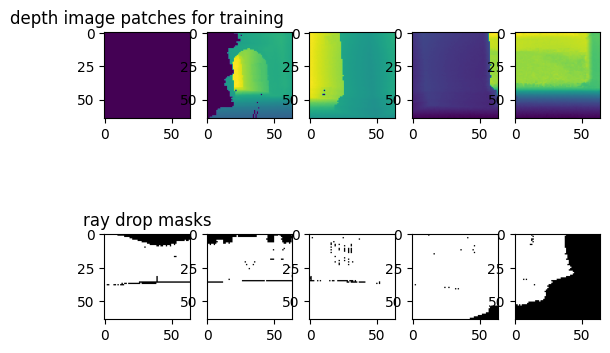

In [358]:
# %matplotlib notebook
fig, ax = p.subplots(2,5)
ax[0,0].set_title("depth image patches for training")

ax[0,0].imshow(images[0,:,:,0])#, vmin=0, vmax=64)
ax[0,1].imshow(images[1,:,:,0])#, vmin=0, vmax=64)
ax[0,2].imshow(images[2,:,:,0])#, vmin=0, vmax=64)
ax[0,3].imshow(images[3,:,:,0])#, vmin=0, vmax=64)
ax[0,4].imshow(images[4,:,:,0])#, vmin=0, vmax=64)

# ax[0,0].imshow(images[-20,:,:,0])#, vmin=0, vmax=64)
# ax[0,1].imshow(images[-19,:,:,0])#, vmin=0, vmax=64)
# ax[0,2].imshow(images[-18,:,:,0])#, vmin=0, vmax=64)
# ax[0,3].imshow(images[-17,:,:,0])#, vmin=0, vmax=64)
# ax[0,4].imshow(images[-16,:,:,0])#, vmin=0, vmax=64)

# ax[0,0].imshow(images[-4,:,:,0])#, vmin=0, vmax=64)
# ax[0,1].imshow(images[-3,:,:,0])#, vmin=0, vmax=64)
# ax[0,2].imshow(images[-2,:,:,0])#, vmin=0, vmax=64)
# ax[0,3].imshow(images[-1,:,:,0])#, vmin=0, vmax=64)
# ax[0,4].imshow(testimg[:,:,0])#, vmin=0, vmax=64)

ax[1,0].set_title("ray drop masks")
ax[1,0].imshow(images[-4,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,1].imshow(images[-3,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,2].imshow(images[-2,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,3].imshow(images[-1,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,4].imshow(testimg[:,:,1],cmap="gray", vmin=0,vmax=1)

In [360]:
num_patches = 8 #number of patches to draw
N_samples = 64 #only used for visualizing all test points

#Ouster OS1-64
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
# phimin = np.deg2rad(-6) 
# phimax = np.deg2rad(27.75)

#test
# phimin, phimax = -(phimax-phimin)/2, (phimax-phimin)/2

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True, sharecam = False) #axes = 4 (simple), 1(scale)
disp=[]

for count in range(num_patches):

    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    look_at_pose = count
    c2w = poses[look_at_pose]
    # c2w = np.eye(3)
    c2w = tf.cast(c2w, tf.float32)
    near = 0.
    far = 64.
    focal = np.array(np.shape(images)[1]/(2*np.tan((phimax-phimin)/2))) #default image size
#     #pinhole camera projection ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     dirs = tf.stack([(i-(W*.5))/focal, -(j-(H*.5))/focal, -tf.ones_like(i)], -1) 
#     rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
#     rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
#     z_vals = tf.linspace(near, far, N_samples) 
#     z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples

#     disp.append(Points(tf.reshape(rays_d, [-1,3]), c = 'light blue',r=5, alpha = 0.75)) #compare here, dirs doesn't invoke c2w
#     disp.append(Points(tf.reshape(rays_d, [-1,3])[:1000], c = 'blue',r=10, alpha = 0.5))
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #reformat for LiDAR depth measurements ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    vert_fov = np.rad2deg(phimax-phimin)
    #[r, theta, phi]
    dirs_test = tf.stack([-tf.ones_like(i), #r
                          #theta
#                           ((i-31.5)/63)*(phimax-phimin),   #was this for squares
                          (i - (1024//(2*n_rots)))  /(2048//(2*n_rots)) * (2*np.pi/n_rots), #for uninterpolated images
                          #phi
                          (phimax + phimin)/2 + ((-j+31.5)/63)*(phimax-phimin) -np.pi/2 #better
                         ], -1)
    dirs_test = tf.reshape(dirs_test,[-1,3])
    dirs_test = LC.s2c(LC, dirs_test)    
    
    #need to rotate red points into same frame as blue points 
    rotm = R.from_euler('xyz', [0,-np.pi/2 + (phimax + phimin)/2,0]).as_matrix()
    dirs_test = dirs_test @ rotm
    dirs_test = dirs_test @ tf.transpose(c2w[:3,:3])
    # aligns dirs, doesn't get pts_flat to work yet
    dirs_test = dirs_test @ (c2w[:3,:3] 
                          @ R.from_euler('xyz', [0,0,np.pi/2]).as_matrix() #looked good but converged slightly off
                          @ np.linalg.pinv(c2w[:3,:3]) )

    rotm_fix = (c2w[:3,:3] 
                @ np.linalg.pinv(c2w[:3,:3]))
    rays_d_test = tf.reduce_sum(dirs_test[..., np.newaxis, :] * rotm_fix, -1) #looks like I need to do this instead
    rays_o_test = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d_test))
    z_vals_test = tf.linspace(near, far, N_samples) 
    z_vals_test += tf.random.uniform(list(rays_o_test.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    #[image_height, image_width, batch_size, 3]
    pts_test = rays_o_test[...,None,:] + rays_d_test[...,None,:] * z_vals_test[...,:,None]
    pts_flat_test = tf.reshape(pts_test, [-1,3])

    cname = np.array([255*(np.random.rand()), 255*(np.random.rand()), 255*(np.random.rand())]).T.tolist()
    disp.append(Points(dirs_test, c = cname, r = 3+2*np.random.rand(), alpha = 0.5))
#     disp.append(Points(dirs_test, c = 'pink', r = 3, alpha = 0.8))
#     disp.append(Points(dirs_test[:1000], c = 'red', r = 5, alpha = 0.8))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #draw frames first pose
    #forward view direction (-z in NeRF c2w convention) 
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0,-0.3])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "yellow"))
    # x
    headings = poses[look_at_pose,:3,:3] @ np.array([0.3,0,0])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "red"))
    #y
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0.3,0])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "green"))
    #z
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0,0.3])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "blue"))

plt.show(disp, "dirs", at = 0)
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [343]:
# print(i)
# print(1024//(2*n_rots))

print(n_rots)
print(360/n_rots)

# test = (i - (1024//(2*n_rots)))
# test = (i - (1024//(2*n_rots)))  /16 * (360/n_rots) #was using this (wrong)
test = (i - (1024//(2*n_rots)))  /(1024//(2*n_rots)) * (360/n_rots) #test

print(test)

16
22.5
tf.Tensor(
[[-22.5      -21.796875 -21.09375  ...  20.390625  21.09375   21.796875]
 [-22.5      -21.796875 -21.09375  ...  20.390625  21.09375   21.796875]
 [-22.5      -21.796875 -21.09375  ...  20.390625  21.09375   21.796875]
 ...
 [-22.5      -21.796875 -21.09375  ...  20.390625  21.09375   21.796875]
 [-22.5      -21.796875 -21.09375  ...  20.390625  21.09375   21.796875]
 [-22.5      -21.796875 -21.09375  ...  20.390625  21.09375   21.796875]], shape=(64, 64), dtype=float32)


In [326]:
print(1024//16)

64
